# 3 layer MNIST

In [147]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist

In [148]:
plt.rcParams['font.size'] = 18

## dataset

In [150]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [151]:
images, labels = (x_train[:1000].reshape(1000, 28*28) / 255, y_train[:1000])

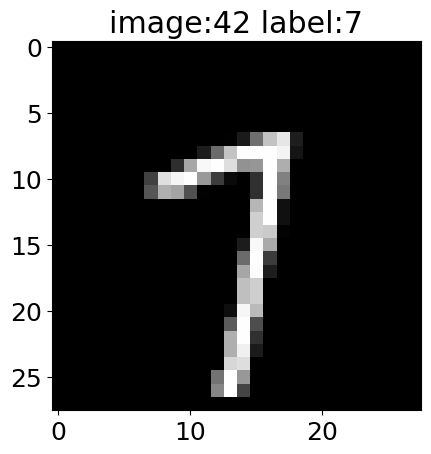

In [152]:
image = 42
fig, ax = plt.subplots()
ax.imshow(x_train[image], cmap='gray')
ax.set_title(f'image:{image} label:{y_train[image]}')

fig.show()

In [153]:
one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1

labels = one_hot_labels

In [154]:
test_images = x_test.reshape((len(x_test), 28*28)) / 255

In [155]:
test_labels = np.zeros((len(y_test), 10))
for i, l in enumerate(y_test):
    test_labels[i][l] = 1

## overfitting neural network

In [156]:
relu = lambda x: (x>=0) * x
relu2deriv = lambda x: x>=0

In [157]:
alpha = 0.005
iterations = 1000
hidden_size = 40
pixels_per_image = 784
num_labels = 10

In [158]:
# initialize nn
np.random.seed(3301)
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

In [159]:
# fit train data
for j in range(iterations):
    error, correct_cnt = 0, 0

    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    sys.stdout.write(f'\r I:{j} Error: {error/float(len(images)):0.5f} Correct: {correct_cnt/float(len(images))}')

 I:999 Error: 0.09641 Correct: 1.0

In [160]:
# test data
error, correct_cnt = 0, 0
for i in range(len(test_images)):
    layer_0 = test_images[i:i+1]
    layer_1 = relu(np.dot(layer_0, weights_0_1))
    layer_2 = np.dot(layer_1, weights_1_2)

    error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
    correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))


sys.stdout.write(f'\r Error: {error/float(len(test_images)):0.5f} Correct: {correct_cnt/float(len(test_images))}')


 Error: 0.98422 Correct: 0.6383

Soooo train data was fitted perfectly but when evaluating on test (unseen) data the network performed terribly. Let's profile train and test errors over iterations...

In [161]:
# (re)initialize nn
np.random.seed(3301)
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

In [162]:
# fit train data
train_errors = []
train_correct_cnts = []

test_errors = []
test_correct_cnts = []

for j in range(iterations):
    error, correct_cnt = 0, 0

    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    train_errors.append(error)
    train_correct_cnts.append(correct_cnt)


    sys.stdout.write(f'\r I:{j} Error: {error/float(len(images)):0.5f} Correct: {correct_cnt/float(len(images))}')

    test_error, test_correct_cnt = 0, 0
    for k in range(len(test_images)):
        layer_0 = test_images[k:k+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        test_error += np.sum((test_labels[k:k+1] - layer_2) ** 2)
        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[k:k+1]))

    test_errors.append(test_error)
    test_correct_cnts.append(test_correct_cnt)

 I:999 Error: 0.09641 Correct: 1.0

In [163]:
train_acc = [i/len(images) for i in train_correct_cnts]
test_acc = [i/len(test_images) for i in test_correct_cnts]

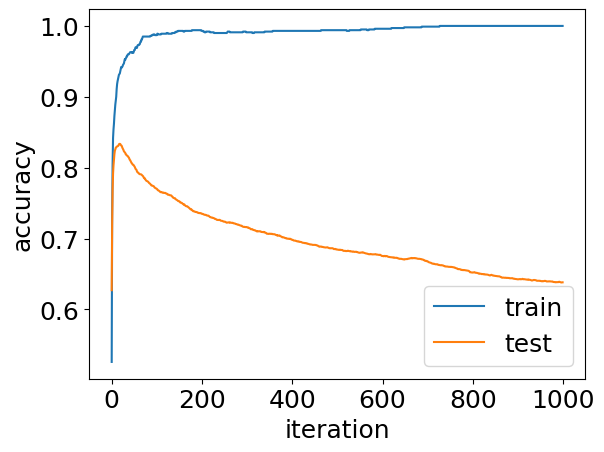

In [164]:
fig, ax = plt.subplots()
ax.plot(train_acc, label='train')
ax.plot(test_acc, label='test')

ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

ax.legend()
fig.show()

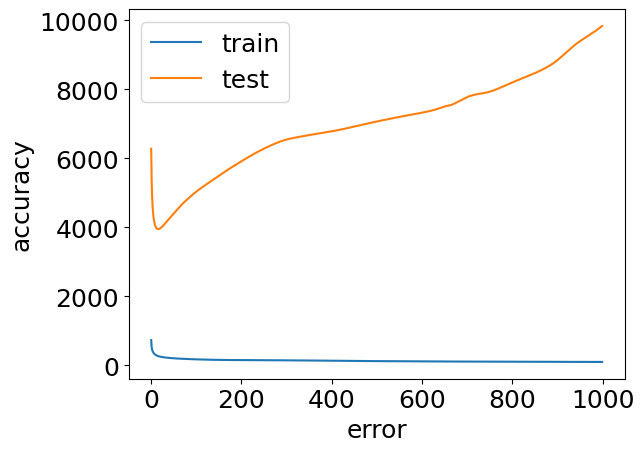

In [165]:
fig, ax = plt.subplots()

ax.plot(train_errors, label='train')
ax.plot(test_errors, label='test')

ax.set_xlabel('error')
ax.set_ylabel('accuracy')

ax.legend()
fig.show()

## Regularization using dropout

In [171]:
# (re)initialize nn
np.random.seed(3301)
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

In [172]:
# fit train data using dropout
train_errors = []
train_correct_cnts = []

test_errors = []
test_correct_cnts = []

for j in range(200):
    error, correct_cnt = 0, 0

    for i in range(len(images)):
        layer_0 = images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))

        # dropout
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2

        layer_2 = np.dot(layer_1, weights_1_2)

        error += np.sum((labels[i:i+1] - layer_2) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1]))

        layer_2_delta = (labels[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)

        layer_1_delta *= dropout_mask

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

    train_errors.append(error)
    train_correct_cnts.append(correct_cnt)


    sys.stdout.write(f'\r I:{j} Error: {error/float(len(images)):0.5f} Correct: {correct_cnt/float(len(images))}')

    test_error, test_correct_cnt = 0, 0
    for k in range(len(test_images)):
        layer_0 = test_images[k:k+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)

        test_error += np.sum((test_labels[k:k+1] - layer_2) ** 2)
        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[k:k+1]))

    test_errors.append(test_error)
    test_correct_cnts.append(test_correct_cnt)

 I:199 Error: 0.39496 Correct: 0.824

In [173]:
train_acc = [i/len(images) for i in train_correct_cnts]
test_acc = [i/len(test_images) for i in test_correct_cnts]

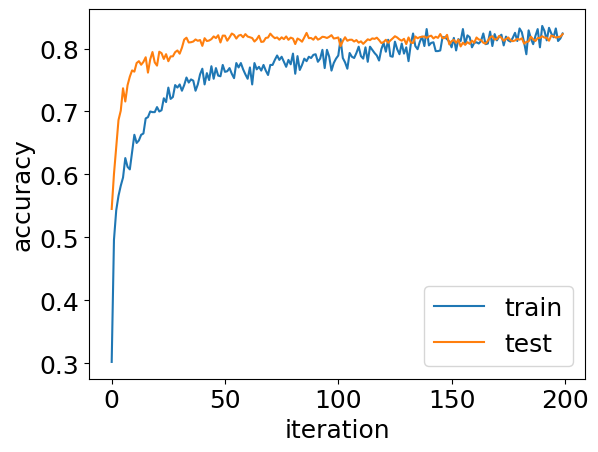

In [174]:
fig, ax = plt.subplots()
ax.plot(train_acc, label='train')
ax.plot(test_acc, label='test')

ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

ax.legend()
fig.show()

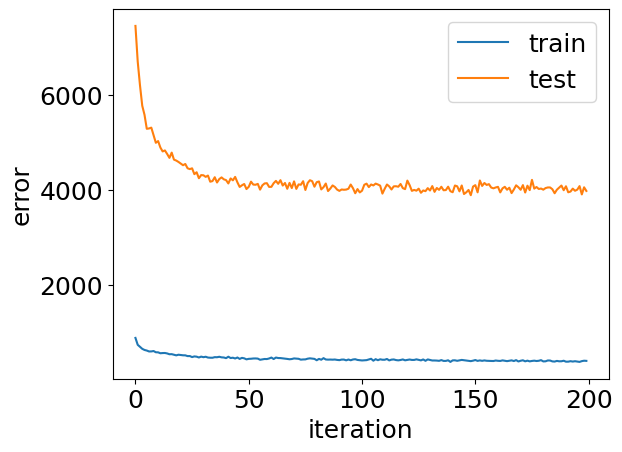

In [178]:
fig, ax = plt.subplots()

ax.plot(train_errors, label='train')
ax.plot(test_errors, label='test')

ax.set_xlabel('iteration')
ax.set_ylabel('error')

ax.legend()
fig.show()